# Understanding the Role of Gender in Book Reviews

## CS 6471: Computational Social Science - Project
Author: Pratyusha Maiti

Affiliation: Georgia Institute of Technology

### Research Objectives
- Do book reviews by different genders differ in stylistic features?
- Do book reviews by different genders differ w.r.t their content?
- Are book reviews written by males perceived as more useful than book reviews written by females?

## TODO:

- Keep unknown gender values and try predicting?

In [215]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
!pip install contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


You should consider upgrading via the '/opt/homebrew/anaconda3/bin/python -m pip install --upgrade pip' command.


### Review Data Cleaning

Parameters:
 - Expand contractions
 - Remove stopwords
 - Remove junk and html
 - Tokenize
 - Lemmatize
 

In [216]:
import contractions 
import re
from nltk.corpus import stopwords
import numpy as np

In [217]:
expand_contractions = True
remove_stopwords = False
format_text = True
tokenize = True
lemmatize = False

def clean_text(text):
    '''Text Preprocessing '''
    
    # Convert words to lower case
    text = text.lower()
    split_text = text.split()
    
    # Expand contractions
    if expand_contractions:
        expanded_words = []   
        for word in split_text:
            expanded_words.append(contractions.fix(word))
        text = " ".join(expanded_words)

    # Format words and remove unwanted characters
    if format_text:
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\<a href', ' ', text)
        text = re.sub(r'&amp;', '', text) 
        text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'<br />', ' ', text)
        text = re.sub(r'\'', ' ', text)
    
    # remove stopwords
    if remove_stopwords:
        split_text = text.split()
        stops = set(stopwords.words("english"))
        word = [w for w in split_text if not w in stops]
        text = " ".join(word)

    # Tokenize each word
    if tokenize:
        text =  nltk.WordPunctTokenizer().tokenize(text)
    
    # Lemmatize each token
    if lemmatize:
        lemm = nltk.stem.WordNetLemmatizer()
        text = list(map(lambda word:list(map(lemm.lemmatize, word)), text))
    
    return text

##### Generate gendered review data

- Genre: Crime, Thriller, Mystery
- Joined by userID
- Dropped NaN rows

In [218]:
import pandas as pd
gendered_data = pd.read_csv('goodreads_names_id_gender.csv')
gendered_data.columns = ['id', 'name', 'username', 'age', 'location', 'joined', 'friends_count','groups_count', 'reviews_count', 'first_name', 'gender', 'user_id']
gendered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852197 entries, 0 to 852196
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             852197 non-null  int64  
 1   name           850616 non-null  object 
 2   username       252735 non-null  object 
 3   age            242043 non-null  float64
 4   location       665382 non-null  object 
 5   joined         820599 non-null  object 
 6   friends_count  820599 non-null  float64
 7   groups_count   820599 non-null  float64
 8   reviews_count  820599 non-null  float64
 9   first_name     850555 non-null  object 
 10  gender         852197 non-null  object 
 11  user_id        852197 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 78.0+ MB


In [219]:
import gzip
import json

def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [220]:
goodreads_reviews_mystery_thriller_crime = load_data('goodreads_reviews_mystery_thriller_crime.json.gz',1849235)
goodreads_reviews_mystery_thriller_crime_df = pd.DataFrame(goodreads_reviews_mystery_thriller_crime)
goodreads_reviews_mystery_thriller_crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849236 entries, 0 to 1849235
Data columns (total 11 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   book_id       object
 2   review_id     object
 3   rating        int64 
 4   review_text   object
 5   date_added    object
 6   date_updated  object
 7   read_at       object
 8   started_at    object
 9   n_votes       int64 
 10  n_comments    int64 
dtypes: int64(3), object(8)
memory usage: 155.2+ MB


In [221]:
gendered_reviews_mtc = pd.merge(goodreads_reviews_mystery_thriller_crime_df, gendered_data, on='user_id', how='left')
gendered_reviews_mtc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1849236 entries, 0 to 1849235
Data columns (total 22 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   book_id        object 
 2   review_id      object 
 3   rating         int64  
 4   review_text    object 
 5   date_added     object 
 6   date_updated   object 
 7   read_at        object 
 8   started_at     object 
 9   n_votes        int64  
 10  n_comments     int64  
 11  id             float64
 12  name           object 
 13  username       object 
 14  age            float64
 15  location       object 
 16  joined         object 
 17  friends_count  float64
 18  groups_count   float64
 19  reviews_count  float64
 20  first_name     object 
 21  gender         object 
dtypes: float64(5), int64(3), object(14)
memory usage: 324.5+ MB


~Incomplete dataset. Dropped the rows with NaN values in features. We find that this brings out the number of reviews by ~1.5 million reviews~

In [222]:
clean_gendered_reviews_mtc = gendered_reviews_mtc
# clean_gendered_reviews_mtc = gendered_reviews_mtc.dropna()
# clean_gendered_reviews_mtc = clean_gendered_reviews_mtc.reset_index(drop=True)
# clean_gendered_reviews_mtc.info()

Dropped the rows with *unknown gender type* and NaN in gender. We find that ratio of female to male reviewers in the test dataset is ~ 2.5:1

In [224]:
clean_gendered_reviews_mtc = clean_gendered_reviews_mtc[clean_gendered_reviews_mtc.gender != 'unknown']
clean_gendered_reviews_mtc = clean_gendered_reviews_mtc.dropna(subset=['gender'])
clean_gendered_reviews_mtc = clean_gendered_reviews_mtc.reset_index(drop=True)
clean_gendered_reviews_mtc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297338 entries, 0 to 1297337
Data columns (total 22 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        1297338 non-null  object 
 1   book_id        1297338 non-null  object 
 2   review_id      1297338 non-null  object 
 3   rating         1297338 non-null  int64  
 4   review_text    1297338 non-null  object 
 5   date_added     1297338 non-null  object 
 6   date_updated   1297338 non-null  object 
 7   read_at        1297338 non-null  object 
 8   started_at     1297338 non-null  object 
 9   n_votes        1297338 non-null  int64  
 10  n_comments     1297338 non-null  int64  
 11  id             1267740 non-null  float64
 12  name           1267740 non-null  object 
 13  username       647310 non-null   object 
 14  age            582643 non-null   float64
 15  location       915311 non-null   object 
 16  joined         1202883 non-null  object 
 17  friends_

In [337]:
clean_gendered_reviews_mtc['gender'].value_counts()

female    954765
male      312975
Name: gender, dtype: int64

In [230]:
gendered_reviews_mtc['review_text'][12]

"I'm a sucker for spy novels, so when someone left this at our bookswap brunch, I zero'd right in on it. I definitely enjoyed it, but didn't think it had much substance. However, it was a perfect novel to relax the mind. \n I enjoyed the descriptions of East Berlin and West Berlin and the Anarchists and Communists. The descriptions of how the double agents were made was a lot of fun. Being a real spy would not be fun, if you really had to pretend to be in a dead-end job with no ambition. It was definitely interesting to be thrown back into a cold-war novel, though at the end I found it a little boring and I started skimming."

### Feature Engineering

- Generate clean review data on the reduced dataset
- Generate writing style features
- Generate content features


In [227]:
!pip install tqdm

You should consider upgrading via the '/opt/homebrew/anaconda3/bin/python -m pip install --upgrade pip' command.


In [ ]:
# gendered_reviews_mtc['review_text'][0] = ' '.join(clean_text(gendered_reviews_mtc['review_text'][0]))

In [231]:
from tqdm import tqdm

def clean_review(reviews_set):
    pd.options.mode.chained_assignment = None
    for idx in tqdm(range(reviews_set.shape[0])):
        reviews_set['review_text'][idx] = ' '.join(clean_text(reviews_set['review_text'][idx]))

In [453]:
male_reviews = clean_gendered_reviews_mtc.loc[clean_gendered_reviews_mtc['gender'] == "male"]
male_reviews = male_reviews.reset_index(drop=True)
female_reviews = clean_gendered_reviews_mtc.loc[clean_gendered_reviews_mtc['gender'] == "female"]
female_reviews = female_reviews.reset_index(drop=True)

In [454]:
train_frames = [male_reviews[:15000], female_reviews[:15000]]
balanced_reviews_mtc = pd.concat(train_frames)
balanced_reviews_mtc = balanced_reviews_mtc.reset_index(drop=True)
test_frames = [male_reviews[15000:20000], female_reviews[15000:20000]]
test_balanced_reviews_mtc = pd.concat(test_frames)
test_balanced_reviews_mtc = test_balanced_reviews_mtc.reset_index(drop=True)

In [455]:
test_balanced_reviews_mtc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  object 
 1   book_id        10000 non-null  object 
 2   review_id      10000 non-null  object 
 3   rating         10000 non-null  int64  
 4   review_text    10000 non-null  object 
 5   date_added     10000 non-null  object 
 6   date_updated   10000 non-null  object 
 7   read_at        10000 non-null  object 
 8   started_at     10000 non-null  object 
 9   n_votes        10000 non-null  int64  
 10  n_comments     10000 non-null  int64  
 11  id             10000 non-null  float64
 12  name           10000 non-null  object 
 13  username       5280 non-null   object 
 14  age            4080 non-null   float64
 15  location       8371 non-null   object 
 16  joined         9709 non-null   object 
 17  friends_count  9709 non-null   float64
 18  groups_

Clean up a small subset of 20000 reviews.

In [456]:
clean_gendered_reviews_mtc_small = balanced_reviews_mtc
clean_review(clean_gendered_reviews_mtc_small)

100%|██████████| 30000/30000 [00:16<00:00, 1821.76it/s]


In [457]:
clean_review(test_balanced_reviews_mtc)

100%|██████████| 10000/10000 [00:04<00:00, 2261.43it/s]


In [347]:
clean_gendered_reviews_mtc_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        30000 non-null  object 
 1   book_id        30000 non-null  object 
 2   review_id      30000 non-null  object 
 3   rating         30000 non-null  int64  
 4   review_text    30000 non-null  object 
 5   date_added     30000 non-null  object 
 6   date_updated   30000 non-null  object 
 7   read_at        30000 non-null  object 
 8   started_at     30000 non-null  object 
 9   n_votes        30000 non-null  int64  
 10  n_comments     30000 non-null  int64  
 11  id             30000 non-null  float64
 12  name           30000 non-null  object 
 13  username       13875 non-null  object 
 14  age            13548 non-null  float64
 15  location       22671 non-null  object 
 16  joined         28512 non-null  object 
 17  friends_count  28512 non-null  float64
 18  groups

In [ ]:
# clean_gendered_reviews_mtc = clean_gendered_reviews_mtc[len(clean_gendered_reviews_mtc.review_text)>0]
# clean_gendered_reviews_mtc = clean_gendered_reviews_mtc.reset_index(drop=True)
# clean_gendered_reviews_mtc.info()

In [ ]:
file_name = "cleaned_gendered_reviews_mtc.csv"
clean_gendered_reviews_mtc.to_csv(file_name)  
# clean_gendered_reviews_mtc.to_csv(file_name, sep='\t', encoding='utf-8')

### Writing Style Analysis

In [234]:
# Features under analysis:
lexical_markers = []
vocabulary_richness = []
complexity = []
hedging = []
use_of_pronouns = []

Notice that the gender is extremely skewed. Might affect performance.

In [391]:
clean_gendered_reviews_mtc_small['gender'].value_counts()

male      15000
female    15000
Name: gender, dtype: int64

#### Get Top 50 common words in the entire reviewset

In [364]:
from collections import Counter
from nltk.probability import FreqDist

def topN_Freq(data, n: int):
    fdist = FreqDist(data)
    return fdist.most_common(n)

def top_50_words(reviews_set):
    top_50 = {}
    dic2 = {}
    for idx in tqdm(range(reviews_set.shape[0])):

        freqDict = topN_Freq(reviews_set['review_text'][idx].split(), 50)
        dic1 = dict(freqDict)
        if idx != 0:
            top_50 = {k: dic1.get(k, 0) + dic2.get(k, 0) for k in set(dic1) | set(dic2)}
        dic2 = dict(Counter(top_50).most_common(50))

    return dict(Counter(top_50).most_common(50))
    len(top_50)


In [392]:
top_50 = top_50_words(clean_gendered_reviews_mtc_small)

100%|██████████| 30000/30000 [00:03<00:00, 8376.72it/s]


#### Get all occurances of the top 50 frequent words in each review

In [366]:
def get_lexical_markers(reviews_set):
    lexical_markers = []
    for idx in tqdm(range(reviews_set.shape[0])):
        freq = Counter(reviews_set['review_text'][idx].split())
        lexical_markers.append(sum(freq.get(k, 0) for k in set(top_50)))
    print(len(lexical_markers))
    return lexical_markers

In [393]:
lexical_markers = get_lexical_markers(clean_gendered_reviews_mtc_small)

100%|██████████| 30000/30000 [00:00<00:00, 39291.59it/s]

30000


In [401]:
test_lexical_markers = get_lexical_markers(test_balanced_reviews_mtc)

100%|██████████| 10000/10000 [00:00<00:00, 38687.20it/s]

10000


In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize

def avgSentLenghtByWord(text):
    tokens = sent_tokenize(text)
    return np.average([len(token.split()) for token in tokens])

In [ ]:
def countFunctionalWords(text):
    functional_words = """a between in nor some upon
    about both including nothing somebody us
    above but inside of someone used
    after by into off something via
    all can is on such we
    although cos it once than what
    am do its one that whatever
    among down latter onto the when
    an each less opposite their where
    and either like or them whether
    another enough little our these which
    any every lots outside they while
    anybody everybody many over this who
    anyone everyone me own those whoever
    anything everything more past though whom
    are few most per through whose
    around following much plenty till will
    as for must plus to with
    at from my regarding toward within
    be have near same towards without
    because he need several under worth
    before her neither she unless would
    behind him no should unlike yes
    below i nobody since until you
    beside if none so up your
    """

    functional_words = functional_words.split()
    count = 0

    for i in text:
        if i in functional_words:
            count += 1

    return count / len(text)

In [241]:
# hedgeWords = pd.read_csv("hedgeWords.txt", sep="\n")
def get_hedge_words(reviews_set):
    hedgefile = open("hedgeWords.txt", "r")
    content = hedgefile.read()
    hedgeWords = content.split("\n")
    hedgefile.close()

    hedging = []
    for idx in tqdm(range(reviews_set.shape[0])):
        hedging.append(sum(x == y for x, y in zip(reviews_set['review_text'], hedgeWords)))
    print(len(hedging))
    return hedging

In [351]:
hedging = get_hedge_words(clean_gendered_reviews_mtc_small)

100%|██████████| 30000/30000 [00:00<00:00, 46515.88it/s]

30000


In [493]:
import math 

def yulesCharacteristicK(words):
    N = len(words)
    K=0
    if N>0:
        freqs = Counter()
        freqs.update(words)
        vi = Counter()
        vi.update(freqs.values())
        M = sum([(value * value) * vi[value] for key, value in freqs.items()])
        K = 10000 * (M - N) / math.pow(N, 2)
    return K

def get_vocabulary_richness(reviews_set):
    vocabulary_richness = []
    for idx in tqdm(range(reviews_set.shape[0])):
        vocabulary_richness.append(yulesCharacteristicK(reviews_set['review_text'][idx]))
    print(len(vocabulary_richness))
    return vocabulary_richness

In [418]:
vocabulary_richness = get_vocabulary_richness(clean_gendered_reviews_mtc_small)
vocabulary_richness.extend(get_vocabulary_richness(test_balanced_reviews_mtc))

 37%|███▋      | 3736/10000 [00:00<00:00, 37350.60it/s]

30000


100%|██████████| 10000/10000 [00:00<00:00, 39344.38it/s]

10000


In [460]:
from nltk.tokenize import sent_tokenize

def avg_wordLength(text):
    return np.average([len(word) for word in text.split()])

def avg_SentLenghtByCh(text):
    tokens = sent_tokenize(text)
    return np.average([len(token) for token in tokens])

def avg_SentLenghtByWord(text):
    tokens = sent_tokenize(text)
    return np.average([len(token.split()) for token in tokens])

def get_complexity(reviews_set):
    complexity_1 = []
    complexity_2 = []
    complexity_3 = []
    for idx in tqdm(range(reviews_set.shape[0])):
        if len(reviews_set['review_text'][idx])>0:
            complexity_1.append(avg_wordLength(reviews_set['review_text'][idx]))
            complexity_2.append(avg_SentLenghtByCh(reviews_set['review_text'][idx]))
            complexity_3.append(avg_SentLenghtByWord(reviews_set['review_text'][idx]))
    #         complexity.append([avg_wordLength(small_gendered_reviews_mtc['review_text'][idx]), avg_SentLenghtByCh(small_gendered_reviews_mtc['review_text'][idx]), avg_SentLenghtByWord(small_gendered_reviews_mtc['review_text'][idx])])
        else:
            complexity_1.append(0)
            complexity_2.append(0)
            complexity_3.append(0)
    print(len(complexity_1), len(complexity_2), len(complexity_3))
    return complexity_1, complexity_2, complexity_3



In [461]:
complexity_1, complexity_2, complexity_3 = get_complexity(clean_gendered_reviews_mtc_small)
complexity_1_t, complexity_2_t, complexity_3_t = get_complexity(test_balanced_reviews_mtc)
complexity_1.extend(complexity_1_t)
complexity_2.extend(complexity_2_t)
complexity_3.extend(complexity_3_t)


 12%|█▏        | 1170/10000 [00:00<00:01, 5907.00it/s]

30000 30000 30000


100%|██████████| 10000/10000 [00:01<00:00, 5588.42it/s]

10000 10000 10000


In [459]:
clean_gendered_reviews_mtc_small['review_text'][29656]

''

Fun fact: lowercase i is not recognised by pos_tagger as a pronoun. A little hacky solution used:

In [476]:
from nltk import word_tokenize, pos_tag

def get_pronouns(reviews_set):
    pos_pronouns = []
    for idx in tqdm(range(reviews_set.shape[0])):
        if len(reviews_set['review_text'][idx])>0:
            pos_pronouns.append(sum(1 for word, pos in pos_tag(word_tokenize(reviews_set['review_text'][idx])) if pos.startswith('PR') or word == "i"))
        else:
            pos_pronouns.append(0)
    print(len(pos_pronouns))
    return pos_pronouns

In [477]:
pronouns = get_pronouns(clean_gendered_reviews_mtc_small)
pronouns.extend(get_pronouns(test_balanced_reviews_mtc))

  0%|          | 39/10000 [00:00<00:26, 379.35it/s]

30000


100%|██████████| 10000/10000 [00:29<00:00, 342.13it/s]

10000


### Testing out Logistic Regression 

In [249]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [482]:
df = pd.DataFrame()

In [484]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   pronouns  40000 non-null  int64
dtypes: int64(1)
memory usage: 312.6 KB


In [396]:
df['frequency'] = lexical_markers

In [403]:
df['frequency'] = test_lexical_markers

In [286]:
df['hedging'] = hedging

In [421]:
df['vocabulary_richness'] = vocabulary_richness

In [480]:
df['complexity1'] = complexity_1
df['complexity2'] = complexity_2
df['complexity3'] = complexity_3

In [483]:
df['pronouns'] = pronouns

In [ ]:
training_data, testing_data = train_test_split(small_gendered_reviews_mtc,random_state = 0)
training_data.info(), testing_data.info()

In [ ]:
Y_train=training_data['gender'].values
Y_test=testing_data['gender'].values

In [ ]:
X_train,X_test,feature_transformer=extract_features(small_gendered_reviews_mtc, 'review_text', training_data,testing_data)



### Train Model, Predict

In [485]:
Y_train=clean_gendered_reviews_mtc_small['gender'].values
Y_test=test_balanced_reviews_mtc['gender'].values

In [486]:
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=10000)
model=scikit_log_reg.fit(df[:30000],Y_train)

[LibLinear]

In [487]:
predicted = model.predict(df[30000:])
predicted

array(['female', 'male', 'male', ..., 'male', 'male', 'female'],
      dtype=object)

In [488]:
probs = model.predict_proba(df[30000:])
probs

array([[0.52560901, 0.47439099],
       [0.48135072, 0.51864928],
       [0.49518264, 0.50481736],
       ...,
       [0.47582475, 0.52417525],
       [0.48135072, 0.51864928],
       [0.50071866, 0.49928134]])

In [489]:
from sklearn.metrics import log_loss,accuracy_score

print(("Accuracy  ") + str(accuracy_score(Y_test, predicted)))

Accuracy  0.548


In [471]:
Y_test_n = [0 if y == "male" else 1 for y in Y_test]
probs_n = [i[0] for i in probs]

In [410]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    


### Writing Style vs LR: Analysis

- 15000 male, 15000 female reviews as training data
- 5000 male, 5000 female reviews as test data


In [415]:
import matplotlib.pyplot as plt

#### Only frequency

Occurance of top 50 words taken into account.

Finding: Not a strong indicator but shows that females use more popular words than males?

In [413]:
print(("Accuracy  ") + str(accuracy_score(Y_test, predicted)))

Accuracy  0.5438


In [414]:
regression_results(Y_test_n, probs_n)

explained_variance:  0.0009
mean_squared_log_error:  0.1233
r2:  0.0008
MAE:  0.4997
MSE:  0.2498
RMSE:  0.4998


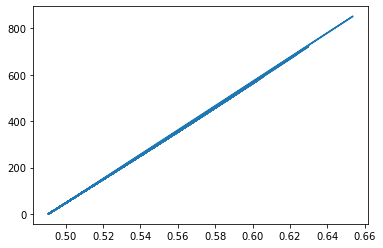

In [417]:
plt.plot(probs_n, df)

#### Only pronouns

Expectation: Females use more pronouns

Results: Inconclusive

In [490]:
print(("Accuracy  ") + str(accuracy_score(Y_test, predicted)))

Accuracy  0.548


In [491]:
regression_results(Y_test_n, probs_n)

explained_variance:  0.0037
mean_squared_log_error:  0.1226
r2:  0.0035
MAE:  0.4973
MSE:  0.2491
RMSE:  0.4991


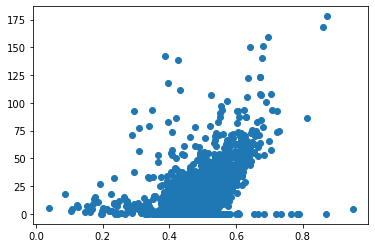

In [492]:
plt.scatter(probs_n, df[30000:])

#### Only vocabulary richness

In [437]:
print(("Accuracy  ") + str(accuracy_score(Y_test, predicted)))

Accuracy  0.4735


In [438]:
regression_results(Y_test_n, probs_n)

explained_variance:  -0.0005
mean_squared_log_error:  0.1236
r2:  -0.0005
MAE:  0.5001
MSE:  0.2501
RMSE:  0.5001


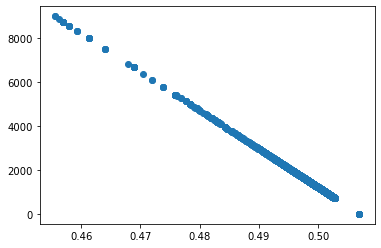

In [439]:
plt.scatter(probs_n, df[30000:])

#### Only complexity

In [472]:
print(("Accuracy  ") + str(accuracy_score(Y_test, predicted)))

Accuracy  0.5338


In [ ]:
regression_results(Y_test_n, probs_n)

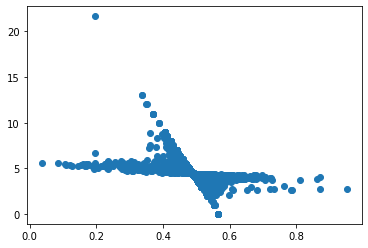

In [473]:
plt.scatter(probs_n, df.iloc[:, 0][30000:])

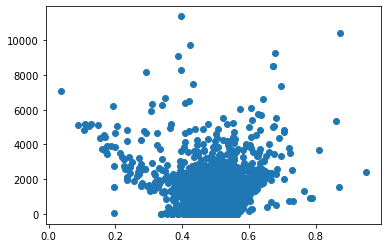

In [474]:
plt.scatter(probs_n, df.iloc[:, 1][30000:])

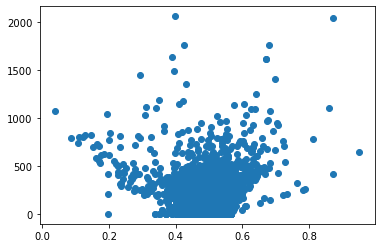

In [475]:
plt.scatter(probs_n, df.iloc[:, 2][30000:])

### Content Features

Perplexity, OOV words, Entropy and other features. Will be explained later :)

In [323]:
import scipy as sc

def ShannonEntropy(words):
    if len(words) == 0:
        return 0
    freqs = Counter()
    freqs.update(words)
    arr = np.array(list(freqs.values()))
    distribution = 1. * arr
    distribution /= max(1, len(words))
    
    H = sc.stats.entropy(distribution, base=2)
    return H


In [324]:
def SimpsonsIndex(words):
    if len(words) < 2:
        return 0
    freqs = Counter()
    freqs.update(words)
    N = len(words)
    n = sum([1.0 * i * (i - 1) for i in freqs.values()])
    D = 1 - (n / (N * (N - 1)))
    return D

In [511]:
def BrunetsMeasureW(words):
    if len(words) < 2:
        return 0
    a = 0.17
    V = float(len(set(words)))
    N = len(words)
    B = (V - a) / (math.log(N))
    return B

In [495]:
entropy = []
simpsons = []
for idx in tqdm(range(clean_gendered_reviews_mtc_small.shape[0])):
    entropy.append(ShannonEntropy(clean_gendered_reviews_mtc_small['review_text'][idx]))
    simpsons.append(SimpsonsIndex(clean_gendered_reviews_mtc_small['review_text'][idx]))

for idx in tqdm(range(test_balanced_reviews_mtc.shape[0])):
    entropy.append(ShannonEntropy(test_balanced_reviews_mtc['review_text'][idx]))
    simpsons.append(SimpsonsIndex(test_balanced_reviews_mtc['review_text'][idx]))
    
    
len(entropy), len(simpsons)

100%|██████████| 10000/10000 [00:00<00:00, 15816.03it/s]


(40000, 40000)

In [496]:
df_content = pd.DataFrame()
df_content['entropy'] = entropy
df_content['simpsons'] = simpsons
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   entropy   40000 non-null  float64
 1   simpsons  40000 non-null  float64
dtypes: float64(2)
memory usage: 625.1 KB


In [514]:
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=10000)
model=scikit_log_reg.fit(df_content[:30000],clean_gendered_reviews_mtc_small['gender'])
predicted = model.predict(df_content[30000:])
predicted

[LibLinear]

array(['female', 'male', 'male', ..., 'male', 'male', 'female'],
      dtype=object)

In [498]:
print(("Accuracy  ") + str(accuracy_score(test_balanced_reviews_mtc['gender'], predicted)))

Accuracy  0.4984


In [499]:
probs = model.predict_proba(df_content[30000:])
probs

array([[0.50223315, 0.49776685],
       [0.49635308, 0.50364692],
       [0.50271591, 0.49728409],
       ...,
       [0.496868  , 0.503132  ],
       [0.5015179 , 0.4984821 ],
       [0.50170814, 0.49829186]])

In [500]:
Y_test_content = [0 if y == "male" else 1 for y in test_balanced_reviews_mtc['gender']]
probs_content = [i[0] for i in probs]

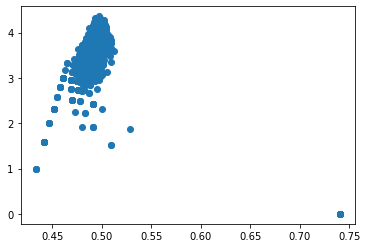

In [501]:
plt.scatter(probs_content, df_content.iloc[:,0][30000:])

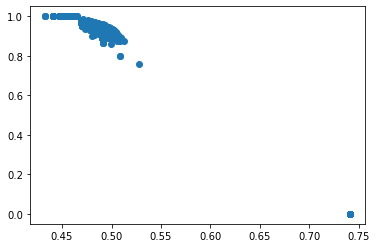

In [502]:
plt.scatter(probs_content, df_content.iloc[:,1][30000:])

In [512]:
brunets = []
for idx in tqdm(range(clean_gendered_reviews_mtc_small.shape[0])):
    brunets.append(BrunetsMeasureW(clean_gendered_reviews_mtc_small['review_text'][idx]))

for idx in tqdm(range(test_balanced_reviews_mtc.shape[0])):
    brunets.append(BrunetsMeasureW(test_balanced_reviews_mtc['review_text'][idx]))
len(brunets)

100%|██████████| 10000/10000 [00:00<00:00, 90683.93it/s]


40000

In [513]:
df_content = pd.DataFrame()
df_content['brunets'] = brunets
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   brunets  40000 non-null  float64
dtypes: float64(1)
memory usage: 312.6 KB


In [515]:
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=10000)
model=scikit_log_reg.fit(df_content[:30000],clean_gendered_reviews_mtc_small['gender'])
predicted = model.predict(df_content[30000:])
predicted

[LibLinear]

array(['female', 'male', 'male', ..., 'male', 'male', 'female'],
      dtype=object)

In [516]:
print(("Accuracy  ") + str(accuracy_score(test_balanced_reviews_mtc['gender'], predicted)))

Accuracy  0.5484


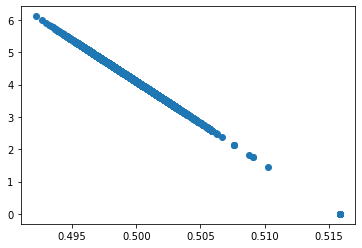

In [518]:
probs = model.predict_proba(df_content[30000:])
Y_test_content = [0 if y == "male" else 1 for y in test_balanced_reviews_mtc['gender']]
probs_content = [i[0] for i in probs]
plt.scatter(probs_content, df_content.iloc[:,0][30000:])

### Some random readability analysis 

In [ ]:
def FleschReadingEase(text, NoOfsentences):
    l = float(len(words))
    scount = 0
    for word in words:
        scount += syllable_count(word)

    I = 206.835 - 1.015 * (l / float(NoOfsentences)) - 84.6 * (scount / float(l))
    return I

In [520]:
def avg_SentLenghtByWord(text):
    if len(text) == 0:
        return 0
    tokens = sent_tokenize(text)
    return np.average([len(token.split()) for token in tokens])
avgSentLen = []
for idx in tqdm(range(clean_gendered_reviews_mtc_small.shape[0])):
    avgSentLen.append(avg_SentLenghtByWord(clean_gendered_reviews_mtc_small['review_text'][idx]))
for idx in tqdm(range(test_balanced_reviews_mtc.shape[0])):
    avgSentLen.append(avg_SentLenghtByWord(test_balanced_reviews_mtc['review_text'][idx]))
len(avgSentLen)

100%|██████████| 10000/10000 [00:00<00:00, 13161.32it/s]


40000

[LibLinear]Accuracy  0.5377
explained_variance:  0.0037
mean_squared_log_error:  0.1226
r2:  0.0035
MAE:  0.4973
MSE:  0.2491
RMSE:  0.4991


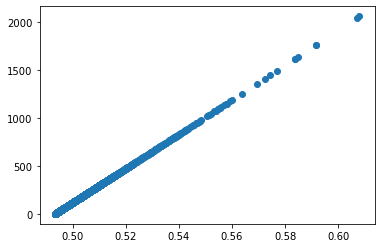

In [522]:
df_content = pd.DataFrame()
df_content['avgSentLen'] = avgSentLen
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=10000)
model=scikit_log_reg.fit(df_content[:30000],clean_gendered_reviews_mtc_small['gender'])
predicted = model.predict(df_content[30000:])
print(("Accuracy  ") + str(accuracy_score(test_balanced_reviews_mtc['gender'], predicted)))
regression_results(Y_test_n, probs_n)
probs = model.predict_proba(df_content[30000:])
Y_test_content = [0 if y == "male" else 1 for y in test_balanced_reviews_mtc['gender']]
probs_content = [i[0] for i in probs]
plt.scatter(probs_content, df_content.iloc[:,0][30000:])

### Analysis on Review Counts, Gender



### A lot of random code, ignore

In [261]:
def extract_features(df,field, training_data,testing_data):
    """Extract features using different methods""" 
        
    # TF-IDF BASED FEATURE REPRESENTATION
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
    tfidf_vectorizer.fit_transform(training_data[field].values)

    train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
    test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)

    return train_feature_set,test_feature_set,tfidf_vectorizer
